# Signal Direction Analysis

A previous analysis showed that using a full sample OLS model gives the $\beta$ that uncovers the original returns. Now its important to start relaxing the full-sample condition, this will be done via taking randomized samples of the signal running OLS and then analyzing the betas

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from   tqdm import tqdm

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryInflationPCA/root/src")
from SignalBootstrapBetaOLS import BootstrapBetaOLS

In [3]:
df_beta = BootstrapBetaOLS().sample_betas()

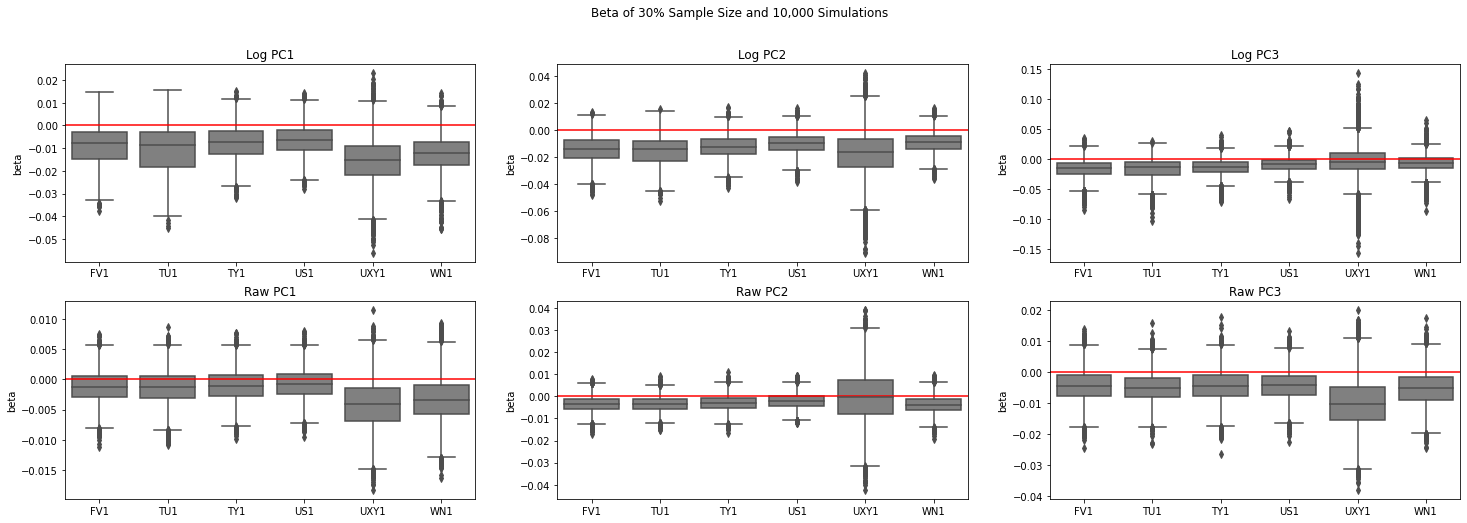

In [4]:
def plot_beta_bootstrap(df_beta: pd.DataFrame, sample_size: float, sims: int) -> plt.Figure:
    
    df_tmp = (df_beta.assign(
        group_var = lambda x: x.input_val.str.split("_").str[0].str.capitalize() + " " + x.variable))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (25,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        df_plot = (df_tmp.query(
            "group_var == @group_var"))

        sns.boxplot(
            x     = "security",
            y     = "beta",
            data  = df_plot,
            ax    = ax,
            color = "grey")

        ax.set_title(group_var)
        ax.set_xlabel("")

        ax.axhline(y = 0, color = "red")

    fig.suptitle("Beta of {}% Sample Size and {:,} Simulations".format(
        round(sample_size * 100),
        sims))
    
plot_beta_bootstrap(df_beta, 0.3, 10_000)

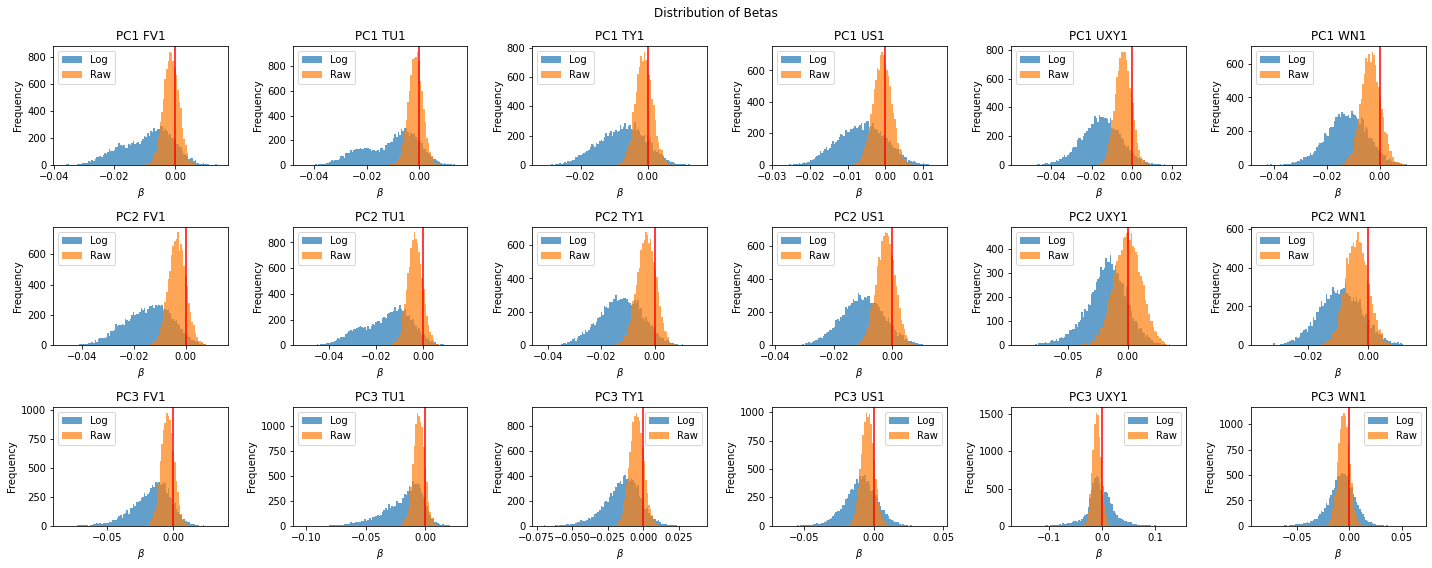

In [5]:
def plot_beta_distribution(df_beta: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_beta.assign(
        group_var = lambda x: x.variable + " " + x.security))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 3, nrows = len(group_vars) // 6, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_tmp.query(
            "group_var == @group_var").
            assign(input_val = lambda x: x.input_val.str.split("_").str[0].str.capitalize()).
            rename(columns = {"input_val": ""}).
            pivot(index = "sim", columns = "", values = "beta").
            plot(
                ax     = ax,
                kind   = "hist",
                bins   = 100,
                alpha  = 0.7,
                title  = group_var,
                xlabel = r"$\beta$"))

        ax.axvline(x = 0, color = "red")

    fig.suptitle("Distribution of Betas")
    plt.tight_layout()
    
plot_beta_distribution(df_beta)

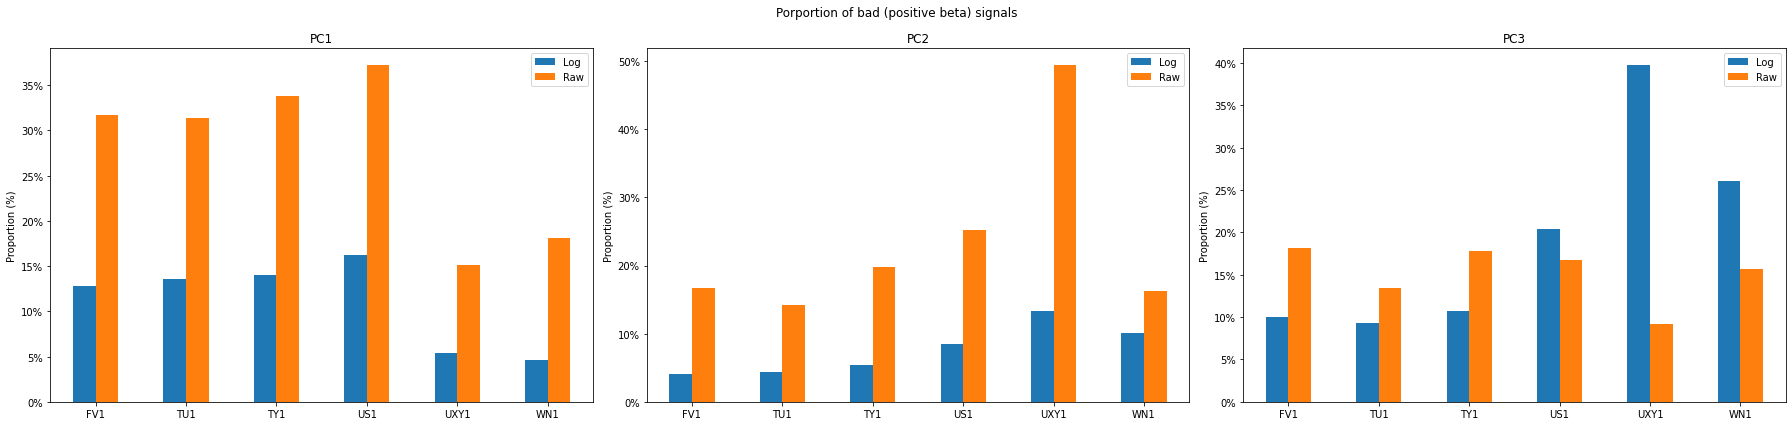

In [7]:
def plot_beta_prop(df_beta: pd.DataFrame) -> plt.Figure: 
    
    df_prop = (df_beta.assign(
        beta_pos = lambda x: np.where(x.beta < 0, "negative", "positive"))
        [["beta_pos", "input_val", "security", "variable", "beta"]].
        groupby(["beta_pos", "input_val", "security", "variable"]).
        agg("count").
        reset_index().
        assign(input_val      = lambda x: x.input_val.str.split("_").str[0].str.capitalize()).
        pivot(index = ["input_val", "security", "variable"], columns = "beta_pos", values = "beta").
        assign(pos_proportion = lambda x: x.positive / (x.negative + x.positive)).
        reset_index().
        pivot(index = ["security", "variable"], columns = "input_val", values = "pos_proportion").
        reset_index())

    pcs = df_prop.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(pcs), figsize = (25,6))

    for pc, ax in zip(pcs, axes.flatten()): 

        (df_prop.query(
            "variable == @pc").
            drop(columns = ["variable"]).
            melt(id_vars = "security").
            rename(columns = {"input_val": ""}).
            pivot(index = "security", columns = "", values = "value").
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                rot    = 0,
                title  = pc,
                ylabel = "Proportion (%)"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("Porportion of bad (positive beta) signals")
    plt.tight_layout()
    
plot_beta_prop(df_beta)